<a href="https://colab.research.google.com/github/rafaeljosem/MNA-ProyectoIntegrador_EQ10/blob/main/Avance-/9Avance9_Equipo10_Evaluation_llama_3_8b_Instruct_bnb_4bit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

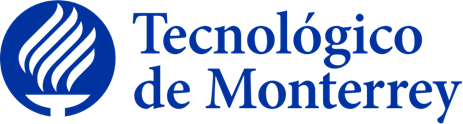

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**

### Dra. Grettel Barceló Alonso
### Dr. Luis Eduardo Falcón Morales
### Mtra. Verónica Sandra Guzmán de Valle

## **Avance 7: Evaluación Modelo Final**

### Domingo 9 de junio de 2024

## **Nombres y matrículas de los integrantes del Equipo 10:**

* Fernando Maytorena Espinosa de los Monteros | A01110946
* Jonathan Garza Bennet | A01793038
* Rafael José Mateo Comprés | A01793054

In this notebook we will be evaluating our final model. The library that we will use for the model evaluation is Deepeval.

### 1. First, we load the libraries

In [ ]:
# Installs Unsloth, Xformers (Flash Attention) and all other packages
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes
!pip install datasets
!pip install deepeval
!pip install python-dotenv

from deepeval import evaluate
from deepeval.evaluate import aggregate_metric_pass_rates
from deepeval.metrics import AnswerRelevancyMetric, HallucinationMetric, GEval
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.dataset import EvaluationDataset
from unsloth import FastLanguageModel
#from peft import PeftModel
from datasets import load_dataset
from datasets.arrow_dataset import Dataset
import json
from dotenv import load_dotenv
#from transformers.tokenization_utils_base import PreTrainedTokenizerBase
#from transformers.modeling_utils import PreTrainedModel

from deepeval.dataset.golden import Golden
#from deepeval.dataset.utils import convert_goldens_to_test_cases
from tqdm import tqdm
import re


  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-5q6by0rx/unsloth_78297d188baf44c6bf712aff314bcb8a
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-5q6by0rx/unsloth_78297d188baf44c6bf712aff314bcb8a
  Resolved https://github.com/unslothai/unsloth.git to commit 7b4235514af9dbe4bcaf69e5c2453483493c88ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Activated, the notebook will execute only a few testcases for demostrantion purposes
#demo_mode = False
#model_name = "unsloth/mistral-7b-v0.3-bnb-4bit"
dataset_url = "JonathanGarza/legal-mx-instruction-dataset-0-6-inst-ft-prompts"
#peft_model_name = 'rafaeljosem/unsloth-mistral-0.3-7b-Instruct-bnb-4bit-8k-tok-context-Mexican-Laws-Inst-FineTuned-step2'

In [ ]:
#model, tokenizer = FastLanguageModel.from_pretrained(
    #model_name = model_name,
    #max_seq_length = 2048,
    #device_map='cuda',
    #load_in_4bit = True,
#)

max_seq_length = 8192

model_fine_tuned, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "JonathanGarza/unsloth-llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2", # MODEL YOU USED FOR TRAINING
        #model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit", # MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length, # Could be any since RoPE Scaling is supported.
        dtype = None, # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
        load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.
        )
FastLanguageModel.for_inference(model_fine_tuned) # Enable native 2x faster inference

adapter_config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.6
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/131 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


adapter_model.safetensors:   0%|          | 0.00/671M [00:00<?, ?B/s]

Unsloth 2024.6 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


### 2. Functions Definition

In this section we define a few helper functions that we will be using for setting the test cases and generating the response from our model.

In [ ]:
def response: str) -> str|None:
    '''
    This function extracts only the answer from the model output
    '''
    match = re.search(r"### Respuesta:\s*(.*?)(?:\s*<\|end_of_text\|>)?$", response)
    if match:
        return match.group(1)
    return None


def get_test_case(datapoint:dict) -> LLMTestCase:
    '''
    Create a test case from a dictionary of datapoints
    '''
    return LLMTestCase(
        input=datapoint.get('input', None),
        actual_output=datapoint.get('actual_output', None),
        expected_output=datapoint.get('expected_output', None),
        context=datapoint.get('context', None)
    )

#def query(model: PreTrainedModel, tokenizer:PreTrainedTokenizerBase,prompt: str) -> str:
def query(model: model_fine_tuned, tokenizer:tokenizer,prompt: str) -> str:
    '''
    Generates the response from the model
    '''

    inputs = tokenizer([prompt], return_tensors = "pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens = max_seq_length, use_cache = True, pad_token_id=tokenizer.eos_token_id)
    result = tokenizer.batch_decode(outputs)

    return extract_response(result[0])

#def generate_test_cases(model: PreTrainedModel, tokenizer: PreTrainedTokenizerBase, datapoints: list[Golden|dict]|Dataset, prompt_template: str) -> list:
def generate_test_cases(model: model_fine_tuned, tokenizer: tokenizer, datapoints: list[Golden|dict]|Dataset, prompt_template: str) -> list:
    '''
    Generates all the test cases from a list of datapoints (called Goldens in deepeval)
    '''
    test_cases = []

    if isinstance(datapoints, Dataset):
        datapoints = convert_hugging_face_dataset_to_goldens(datapoints)
    for golden in tqdm(datapoints, desc='Generating test cases'):
        datapoint = golden
        print(datapoint)

        if (isinstance(golden, Golden)):
            datapoint = json.loads(golden.model_dump_json())

        prompt = prompt_template.format(
                datapoint['input'], # Instrucción
                #datapoint['instruction'], # Instrucción
                "", # Entrada
                "", # Salida - leave this blank for generation!
            )
        datapoint['actual_output'] = query(model, tokenizer, prompt)
        test_cases.append(get_test_case(datapoint))
    return test_cases

def exclude_test_cases_with_empty_outputs(testcases: list[LLMTestCase], print_results = True)->list[LLMTestCase]:
    cleaned_testcases = []
    for index,testcase in enumerate(testcases):
        if type(testcase.actual_output) == str:
            cleaned_testcases.append(testcases.pop(index))
            continue

    if print_results:
        print (f'A total of {len(testcases) - len(cleaned_testcases)} testcases were removed from the set')
    return cleaned_testcases

def convert_hugging_face_dataset_to_goldens(dataset: Dataset)->list[Golden]:

    goldens = []

    for datapoint in dataset:
        if (type(datapoint['context']) != str):
            continue#We need context for some tests
        test_case = Golden(
            input = datapoint['instruction'],
            expected_output = datapoint['output'],
            context = [datapoint['context']]
        )

        test_case.expected_output = datapoint['output']

        goldens.append(test_case)

    return goldens




In [ ]:
#Developing new test cases function

def create_text_cases(model_fine_tuned, prompt, dataset, max_new_tokens):

  FastLanguageModel.for_inference(model_fine_tuned) # Enable native 2x faster inference

  inputs = tokenizer(
  [
      alpaca_based_prompt.format(
          dataset['instruction'], # Instrucción
          #dataset7['context'], # Contexto
          [],
          "", # Salida - leave this blank for generation
      )
  ]<, return_tensors = "pt").to("cuda")

  outputs_fine_tuned = model_fine_tuned.generate(**inputs, max_new_tokens, use_cache = True)
  outputs_fine_tuned_decoded = tokenizer.batch_decode(outputs_fine_tuned)

  test_case = LLMTestCase(
    input=dataset['instruction'],
    actual_output=extract_response(outputs_fine_tuned_decoded[0]),
    context=dataset['context']
  )

  print('\n\nFine tuned model:\n\n')
  print(outputs_fine_tuned_decoded)
  print('\n\n')

### 2. Creating the test dataset

For creating the dataset, we need to access OpenAI Api since we'll be using a synthetic dataset created from the law files used for this project.

In [ ]:
dataset = load_dataset(dataset_url, split = "test[10:16]")
#test_set = dataset['test']

In [ ]:
#We need a API key. Please, be sure to have a .env file in the same directory of this notebook.
import os
#We need a API key .env path
dot_env_path = '/content/drive/MyDrive/MNA/Proyecto Integrador/.env'

#Load .env file
load_dotenv(dot_env_path)

#Get API Key
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

### 3. Setting up the Finetuned Model

We proceed to download the main model, which was a quantized version of the Llama-3-8b. In order to run this code, it'necessary to have cuda device.

Now we donwload the PEFT model containing the trained weights

In [ ]:

#model = PeftModel.from_pretrained(model, model_id=peft_model_name)
#FastLanguageModel.for_inference(model)

We define the prompt that we will provide to the Llama Model

In [ ]:
#Base prompt
alpaca_based_prompt = """A continuación se muestra una instrucción que describe una tarea, junto con un contexto que proporciona más información. Escribe una respuesta que complete adecuadamente la instrucción

### Instrucción:
{}

### Contexto:
{}

### Respuesta:
{}"""

### 4. Evaluating the Model

First, let's load the dataset containing all the goldens

Now, we create the test cases from the goldens. For the real evaluation we used 250+ testcases, For demonstration purposes, we will use only 10 testcases.

In [ ]:
#len(test_set)
len(dataset)

5

In [ ]:
#dataset = test_set.train_test_split(test_size=0.2)

In [ ]:
dataset['instruction']

['¿Qué deben hacer las entidades o intermediarios financieros si desean beneficiarse de la reducción del veinte por ciento en el pago de las multas impuestas por el Banco de México según el Artículo 67 de la Ley del Banco de México?',
 'Resume los cambios realizados en los artículos 13 y 14 de la Ley del Instituto Mexicano de la Juventud de acuerdo con la reforma del artículo 28.',
 '¿Qué recomendaciones legales se deben seguir al aplicar las disposiciones del Artículo Segundo de la Ley Nacional de Ejecución Penal?',
 '¿Qué deben hacer las entidades que soliciten adherirse al Sistema Nacional de Coordinación Fiscal según la Ley de Coordinación Fiscal?',
 'Resume el contenido del Artículo 4 de la Ley de Ciencia y Tecnología en relación con la Investigación y el desarrollo tecnológico.',
 'Redacta una cláusula para un contrato que regule las remuneraciones de los servidores públicos según la Ley Federal de Remuneraciones de los Servidores Públicos.']

In [ ]:
test_cases = generate_test_cases(model_fine_tuned, tokenizer, dataset, alpaca_based_prompt)

Generating test cases:   0%|          | 0/5 [00:00<?, ?it/s]

input='Resume los cambios realizados en los artículos 13 y 14 de la Ley del Instituto Mexicano de la Juventud de acuerdo con la reforma del artículo 28.' actual_output=None expected_output='La reforma al artículo 28 de la Ley del Instituto Mexicano de la Juventud implicó modificaciones en los artículos 13 y 14. En el artículo 13, se cambió...' context=['Ley del Instituto Mexicano de la Juventud - Artículo Vigésimo Octavo. Se reforman los artículos 8, fracción I, inciso d); 13, primer párrafo; y 14 de la Ley del Instituto Mexicano de la Juventud, para quedar como sigue: ...... TRANSITORIOS Primero. El presente decreto entrará en vigor al día siguiente de su publicación en el Diario Oficial de la Federación. Segundo. A partir de la fecha en que entre en vigor este Decreto, se dejan sin efecto las disposiciones que contravengan o se opongan al mismo. México, D.F., a 21 de febrero de 2012.- Dip. Guadalupe Acosta Naranjo, Presidente.- Sen. José González Morfín, Presidente.- Dip. Laura Arizm

Generating test cases:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

input='¿Qué recomendaciones legales se deben seguir al aplicar las disposiciones del Artículo Segundo de la Ley Nacional de Ejecución Penal?' actual_output=None expected_output='Al aplicar las disposiciones del Artículo Segundo de la Ley Nacional de Ejecución Penal, es fundamental seguir las recomendaciones legales de respetar los derechos humanos de las personas privadas de la libertad, garantizar la correcta ejecución de las penas y medidas de seguridad, y cumplir con las normativas federales y locales vigentes en materia penitenciaria.' context=['Ley Nacional de Ejecución Penal - Artículo Segundo. La presente Ley tiene por objeto regular la ejecución de las penas, las medidas de seguridad, las medidas cautelares y las medidas terapéuticas en el ámbito federal y local, con el fin de garantizar el respeto a los derechos humanos de las personas privadas de la libertad.'] retrieval_context=None additional_metadata=None comments=None source_file=None


Generating test cases:  40%|████      | 2/5 [00:06<00:09,  3.27s/it]

input='¿Qué deben hacer las entidades que soliciten adherirse al Sistema Nacional de Coordinación Fiscal según la Ley de Coordinación Fiscal?' actual_output=None expected_output='Las entidades que soliciten adherirse al Sistema Nacional de Coordinación Fiscal deben celebrar un convenio con la Secretaría de Hacienda y Crédito Público. Dichas entidades participarán en el total de los impuestos federales y en los otros ingresos que señale esta Ley mediante la distribución de los fondos que en la misma se establecen.' context=['Ley de Coordinación Fiscal - Artículo 1. Esta Ley tiene por objeto coordinar el sistema fiscal de la Federación con las entidades federativas, así como con los municipios y demarcaciones territoriales, para establecer la participación que corresponda a sus haciendas públicas en los ingresos federales; distribuir entre ellos dichas participaciones; fijar reglas de colaboración administrativa entre las diversas autoridades fiscales; constituir los organismos en mater

Generating test cases:  60%|██████    | 3/5 [00:11<00:08,  4.15s/it]

input='Resume el contenido del Artículo 4 de la Ley de Ciencia y Tecnología en relación con la Investigación y el desarrollo tecnológico.' actual_output=None expected_output='El Artículo 4 de la Ley de Ciencia y Tecnología define términos clave como Investigación, Innovación, Desarrollo tecnológico, entre otros, estableciendo su alcance y significado en el contexto de la ciencia y la tecnología en México.' context=['Ley de Ciencia y Tecnología - Artículo 4. Para los efectos de esta Ley se entenderá por: I. CONACyT, el Consejo Nacional de Ciencia y Tecnología; II. Programa, el Programa Especial de Ciencia, Tecnología e Innovación; III. Investigación, aquélla que abarca la investigación científica, básica y aplicada en todas las áreas del conocimiento, así como la investigación tecnológica; IV. Consejo General, al Consejo General de Investigación Científica, Desarrollo Tecnológico e Innovación; V. Foro, al Foro Consultivo Científico y Tecnológico; VI. Registro, al Registro Nacional de In

Generating test cases:  80%|████████  | 4/5 [00:15<00:04,  4.13s/it]

input='Redacta una cláusula para un contrato que regule las remuneraciones de los servidores públicos según la Ley Federal de Remuneraciones de los Servidores Públicos.' actual_output=None expected_output='CLÁUSULA PRIMERA.- REMUNERACIONES. El presente contrato regula las remuneraciones de los servidores públicos de acuerdo con lo establecido en la Ley Federal de Remuneraciones de los Servidores Públicos, garantizando que se respeten las disposiciones sobre remuneraciones para los servidores públicos de los poderes de la Unión y otros entes públicos federales.' context=['Ley Federal de Remuneraciones de los Servidores Públicos - Artículo 1. La presente Ley es reglamentaria de los artículos 75 y 127 de la Constitución Política de los Estados Unidos Mexicanos y tiene por objeto regular las remuneraciones que perciben los servidores públicos de los poderes de la Unión y todos los demás entes públicos federales incluidos aquellos dotados de autonomía constitucional.'] retrieval_context=Non

Generating test cases: 100%|██████████| 5/5 [00:20<00:00,  4.06s/it]


In [ ]:
test_cases

[LLMTestCase(input='Resume los cambios realizados en los artículos 13 y 14 de la Ley del Instituto Mexicano de la Juventud de acuerdo con la reforma del artículo 28.', actual_output='La reforma del artículo 28 de la Ley del Instituto Mexicano de la Juventud modificó los artículos 13 y 14, estableciendo nuevos requisitos y procedimientos para el Instituto.<|eot_id|>', expected_output='La reforma al artículo 28 de la Ley del Instituto Mexicano de la Juventud implicó modificaciones en los artículos 13 y 14. En el artículo 13, se cambió...', context=['Ley del Instituto Mexicano de la Juventud - Artículo Vigésimo Octavo. Se reforman los artículos 8, fracción I, inciso d); 13, primer párrafo; y 14 de la Ley del Instituto Mexicano de la Juventud, para quedar como sigue: ...... TRANSITORIOS Primero. El presente decreto entrará en vigor al día siguiente de su publicación en el Diario Oficial de la Federación. Segundo. A partir de la fecha en que entre en vigor este Decreto, se dejan sin efecto 

Sometimes the Llama model generates an empty response. Due to time constraints, we were not able to investigate this unexpected behaviour. Since a testcase with empty output would generate an error during evaluation, we must exclude it here from the test dataset.

In [ ]:
test_cases = exclude_test_cases_with_empty_outputs(test_cases)

A total of -1 testcases were removed from the set


In [ ]:
dataset_test_cases = EvaluationDataset(test_cases)

In [ ]:
from deepeval.dataset.utils import convert_test_cases_to_goldens

goldens = convert_test_cases_to_goldens(dataset_test_cases)

In [ ]:
backup_dataset = EvaluationDataset(goldens = goldens)
backup_dataset.save_as('json', '/content/drive/MyDrive/MNA/Proyecto Integrador/llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_cases')

Evaluation dataset saved at /content/drive/MyDrive/MNA/Proyecto Integrador/llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_cases/20240615_080841.json!


'/content/drive/MyDrive/MNA/Proyecto Integrador/llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_cases/20240615_080841.json'

We will evaluating our model against three metrics:

* Hallucination
* Correctness
* Answer Relevancy

The evaluation process uses GPT-3.5-turbo under the hood. So, it's necessary to have an OpenAI Key in order to run this section of the notebook.

On another note, we are using conservative threshold values since all the datasets that were used in this project were synthetic. It's reasonable to expect that the model's performance has been affected by this.

In [ ]:
#with open('./content/drive/MyDrive/MNA/Proyecto Integrador/llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_cases'):

In [ ]:
hallucination_metric = HallucinationMetric(threshold=0.3, model='gpt-3.5-turbo')
correctness_metric = GEval(
    threshold=0.7,
    model='gpt-3.5-turbo',
    name="Correctness",
    criteria="Determina si el resultado actual (actual output) es objetivamente correcto basado en la salida esperada (expected output).",
    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT],
)
answer_relevancy_mertric = AnswerRelevancyMetric(model='gpt-3.5-turbo', threshold=0.7)

In [ ]:
#hallucination_metric = HallucinationMetric(threshold=0.3, model='gpt-3.5-turbo')
#correctness_metric = GEval(
#    threshold=0.7,
#    model='gpt-3.5-turbo',
#    name="Correctness",
#    criteria="Determina si el resultado actual (actual output) es objetivamente correcto basado en la salida esperada (expected output).",
#    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT],
#)
#answer_relevancy_mertric = AnswerRelevancyMetric(model='gpt-3.5-turbo', threshold=0.7)

No we get the results from the evaluation

In [ ]:
results = evaluate(dataset_test_cases, [hallucination_metric, answer_relevancy_mertric, correctness_metric], show_indicator=False, use_cache=True, ignore_errors=True, print_results=False)

Event loop is already running. Applying nest_asyncio patch to allow async execution...


/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


All metrics errored for all test cases, please try again.

In [ ]:
results

[TestResult(success=False, metrics=[<deepeval.metrics.hallucination.hallucination.HallucinationMetric object at 0x7f6440b779d0>, <deepeval.metrics.answer_relevancy.answer_relevancy.AnswerRelevancyMetric object at 0x7f6440b77a30>, <deepeval.metrics.g_eval.g_eval.GEval object at 0x7f6440b77910>], input='Resume los cambios realizados en los artículos 13 y 14 de la Ley del Instituto Mexicano de la Juventud de acuerdo con la reforma del artículo 28.', actual_output='La reforma del artículo 28 de la Ley del Instituto Mexicano de la Juventud modificó los artículos 13 y 14, estableciendo nuevos requisitos y procedimientos para el Instituto.<|eot_id|>', expected_output='La reforma al artículo 28 de la Ley del Instituto Mexicano de la Juventud implicó modificaciones en los artículos 13 y 14. En el artículo 13, se cambió...', context=['Ley del Instituto Mexicano de la Juventud - Artículo Vigésimo Octavo. Se reforman los artículos 8, fracción I, inciso d); 13, primer párrafo; y 14 de la Ley del In

In [ ]:
with open('/content/drive/MyDrive/MNA/Proyecto Integrador/llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_results') as f:
    #results = json.load(f)

clean_results = []
for test_case in results['testCases']:
    for metric in test_case['metricsMetadata']:
        if 'error' in metric and metric['error'] == 'Evaluation LLM outputted an invalid JSON. Please use a better evaluation model.':
            continue

        clean_results.append(metric)

TypeError: list indices must be integers or slices, not str

In [ ]:
#len(clean_results)

In [ ]:
#clean_results[10]
results['metric']

TypeError: list indices must be integers or slices, not str

In [ ]:
#clean_results[0]

In [ ]:
hallucination_metric = []
#for metric in clean_results:
for metric in results:
        if metric['metric'] == 'Hallucination':
            hallucination_metric.append(metric)



hallucination_metric[0]

TypeError: 'TestResult' object is not subscriptable

In [ ]:
len(hallucination_metric)

0

In [ ]:
passed = 0

for metric in hallucination_metric:
    if metric['success'] == True:
        passed+=1


passed/len(hallucination_metric)

ZeroDivisionError: division by zero

In [ ]:
len(hallucination_metric)

In [ ]:
passed

Now we print the scores:

In [ ]:
scores = aggregate_metric_pass_rates(results)

if not demo_mode:
    with open('/content/drive/MyDrive/MNA/Proyecto Integrador/llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_results/test_results.json', 'w') as f:
        json.dump(scores, f)



Overall Metric Pass Rates

HallucinationMetric: 66.67% pass rate
AnswerRelevancyMetric: 66.67% pass rate
GEval: 66.67% pass rate




NameError: name 'demo_mode' is not defined

In case the notebook is in demo mode, we load the real scores and print them out:

In [ ]:
if demo_mode:
    with open('/content/drive/MyDrive/MNA/Proyecto Integrador/llama-3-8b-Instruct-bnb-4bit-8k-tok-context-Mexican-Federal-Laws-Inst-FineTuned-step2/test_results/test_results.json') as f:
        scores = json.load(f)

    print("\n" + "=" * 70 + "\n")
    print("Overall Metric Pass Rates\n")
    for metric, pass_rate in scores.items():
        print(f"{metric}: {pass_rate:.2%} pass rate")
    print("\n" + "=" * 70 + "\n")


NameError: name 'demo_mode' is not defined

### 5. Conclusions

The model has a good performance on the GEval and Answer Relevancy metrics (92.62% and 89.93$ respectively). Nonetheless, the hallucination metric is not satisfactory (4.03%) and must be improved. There are several steps that can be taken in order to improve this metric:

* Train the model in a larger dataset (currently we used 5,000 entries)
* Use human annotators for creating high quality datasets
* Train other models and compare to the one used in this project.

Because the model has low score in the hallucination metric, it's still not ready for production.